In [ ]:
%load_ext autoreload
%autoreload 2

In [104]:
import sys
import os 
sys.path.append(os.path.abspath('../'))
import torch
from time import time
from tqdm import tqdm
import drjit as dr
import mitsuba as mi
import numpy as np
import matplotlib.pyplot as plt 
from IPython.display import clear_output
import torch.nn as nn
import torch.nn.functional as F
import functorch as ft


from convolutions import *
from utils_fns import *
from utils_general import update_sigma_linear, run_scheduler_step, plt_errors, show_with_error
from optimizations import *
from utils_optim import run_optimization, run_grad_optimization, run_cg_optimization, run_bfgs_optimization
from utils_general import run_scheduler_step
from utils_mitsuba import get_mts_rendering, render_smooth
from read_scenes import create_scene_from_xml

if torch.cuda.is_available():
    device = 'cuda'
    print("is available")
    mi.set_variant('cuda_ad_rgb')

is available


# Setup rendering

In [5]:
def apply_rotation(rotation, p, mat_id, init_vpos, factor=20):
    if isinstance(rotation, torch.Tensor):
        if rotation.dim() < 1:
            rotation = rotation.unsqueeze(0)
        rotation = rotation.tolist()[0]
    rot = mi.Transform4f.rotate([0, 1, 0], rotation * factor)
    p[mat_id] = dr.ravel(rot @ init_vpos)
    p.update()

def apply_color(color, p, mat_id, **kwargs):
    if isinstance(color, torch.Tensor):
        color = color.squeeze().tolist()
    p[mat_id] = mi.Color3f(color[0], color[1], color[2])
    p.update()

def setup_coffecup_scene(hparams):
    xmlpath = '../scenes/coffee_mug/classic-mug-backdrop-camMoreFrontal.xml'
    scene = create_scene_from_xml(xmlpath, resx=hparams['resx'], resy=hparams['resy'], integrator=hparams['integrator'],
                                  maxdepth=hparams['max_depth'], reparam_max_depth=hparams['reparam_max_depth'])
    params = mi.traverse(scene)
    mat_pos_id = 'PLYMesh_1.vertex_positions' # rotation
    mat_color_id = 'mat-Mug.brdf_0.reflectance.value' # color
    initial_vertex_positions = dr.unravel(mi.Point3f, params[mat_pos_id])
    # mat_id = mat_color_id
    mat_id = mat_pos_id
    return scene, params, mat_id, initial_vertex_positions

def image_for_plotting(img):
    '''
    plot given torch tensor as img
    '''
    if img.shape[0] == 3:
        img = img.permute(1, 2, 0)
    img = img**.4545
    img_normalized = (img - img.min()) / (img.max() - img.min())
    return img_normalized.cpu().float().numpy()

rot is tensor([10.6053], device='cuda:0')


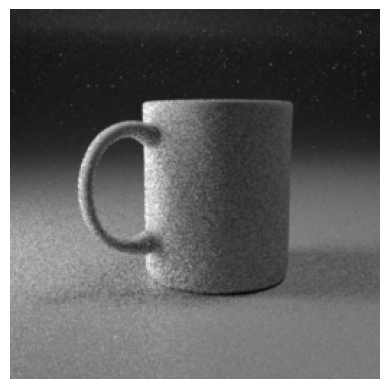

In [126]:
hparams = {'resx': 256,
            'resy': 256,
            'nsamples': 1,
            'sigma': 0.1,
            'render_spp': 32,
            'initial_translation': [9],
            'gt_translation': [0],
            'integrator': 'path',
            'max_depth': 6,
            'reparam_max_depth': 2}

scene, params, mat_id, initial_vertex_positions = setup_coffecup_scene(hparams) # rotation

ctx_args = {'scene': scene, 'params': params, 'spp': hparams['render_spp'],                     # rendering
            'init_vpos': initial_vertex_positions, 'mat_id': mat_id, #'update_fn': update_fn,    # rendering
            'sampler': 'importance', 'antithetic': True, 'nsamples': hparams['nsamples'],       # ours
            'sigma': hparams['sigma'], 'device': device}  

# gt_rot = torch.rand((1,)).to(device) * 9
# gt_color = torch.rand((3,)).to(device)

# generate input image
# reference_image = get_mts_rendering(gt_rot, update_fn, ctx_args)
# reference_image = get_mts_rendering(gt_color, apply_color, ctx_args)

def gen_data(gt_param=None, device='cuda'):
    '''
    generate gt data and reference image
    '''
    # gt_color = torch.rand((1,3)).to(device)
    if gt_param is None:
        gt_param = torch.rand((1,)).to(device) * 5 + 7
    # reference_image = get_mts_rendering(gt_color, apply_color, ctx_args)
    reference_image = get_mts_rendering(gt_param, apply_rotation, ctx_args)
    reference_image = reference_image.permute(2, 0, 1)
    return gt_param, reference_image

# gt_color, reference_image = gen_data()
# print(f'Color is {gt_color}')
# reference_image = image_for_plotting(reference_image)
# plt.imshow(reference_image)
# plt.axis('off')
# plt.show()
gt_rot, reference_image = gen_data()
print(f'rot is {gt_rot}')
reference_image = image_for_plotting(reference_image)
plt.imshow(reference_image)
plt.axis('off')
plt.show()
    

# Generate dataset

In [124]:
gt_params = torch.linspace(7, 11, 100).to(device)

# CNN

In [147]:
class CNN(nn.Module):
    def __init__(self, n_params):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.pool2 = nn.MaxPool2d(kernel_size=4, stride=4, padding=0)
        self.fc1 = nn.Linear(16 * 8 * 8, 256)  # Assuming input image size is 256x256
        self.fc2 = nn.Linear(256, n_params)
        
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool2(F.relu(self.conv3(x)))
        x = x.view(-1, 16*8*8)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        # x = F.sigmoid(self.fc2(x))
        # x = F.relu(self.fc2(x))
        x = self.fc2(x)
        return x

# Train with encoder only

In [148]:
n_params = 3  # Number of output parameters
model = CNN(n_params)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total number of parameters: {pytorch_total_params}')
criterion = nn.MSELoss()
model.to(device)

# optimization - encoder only
max_step = 5000
for i in range(max_step):
    gt_color, input_image = gen_data()
    output_color = model(input_image)

    loss = criterion(output_color, gt_color)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print(f'Loss at step {i}: {loss.item()}')
    if loss.item() < 1e-5:
        print(f'Converged at step {i}')
        break


Total number of parameters: 268259
Loss at step 0: 106.872802734375


/root/miniconda3/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss at step 100: 0.10960056632757187


KeyboardInterrupt: 

Final loss: 4.754169822263066e-06
GT color: tensor([[0.7860, 0.2936, 0.2092]], device='cuda:0')
Output color: tensor([[0.7832, 0.3062, 0.1735]], device='cuda:0', grad_fn=<AddmmBackward0>)


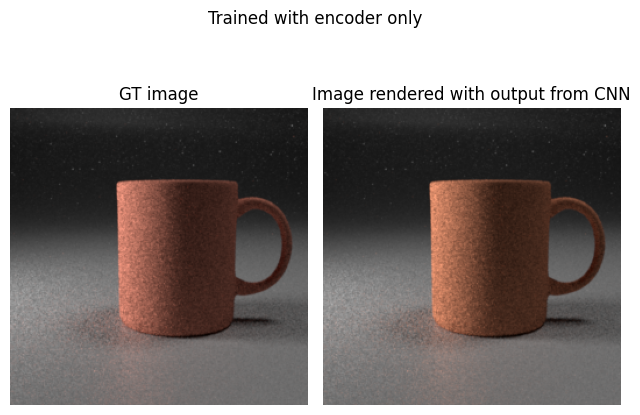

In [13]:
print("Final loss:", loss.item())
test_color, test_image = gen_data()
output_color = model(test_image)
gt_image = image_for_plotting(test_image)
output_image = image_for_plotting(get_mts_rendering(output_color, apply_color, ctx_args))
print(f'GT color: {test_color}')
print(f'Output color: {output_color}')
plt.subplot(1, 2, 1)
plt.imshow(gt_image)
plt.title('GT image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(output_image)
plt.title('Image rendered with output from CNN')
plt.axis('off')
plt.suptitle('Trained with encoder only')
plt.tight_layout()
plt.show()

# Add FR22 as decoder

## Setup

In [160]:
update_fn = apply_rotation
hparams['sigma'] = 0.5
ctx_args = {'scene': scene, 'params': params, 'spp': hparams['render_spp'],                     # rendering
            'init_vpos': initial_vertex_positions, 'mat_id': mat_id, 'update_fn': update_fn,    # rendering
            'sampler': 'importance', 'antithetic': True, 'nsamples': hparams['nsamples'],       # ours
            'sigma': hparams['sigma'], 'device': device}  

f_args = {'update_fn': update_fn, 'ctx_args': ctx_args}
kernel_args = {'sigma': hparams['sigma']}
sampler_args = {'sigma': hparams['sigma'], 'is_antithetic': ctx_args['antithetic'], 'dir':(0,0)}

## Training

In [164]:
# optimization - with FR22 as decoder
n_params = 1  # Number of output parameters
model = CNN(n_params)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()
model.to(device)

diff_func = smoothFn_gradient_mi(func=render_smooth, n=ctx_args['nsamples'], f_args=f_args,
                        kernel_args=kernel_args, sampler_args=sampler_args, device=device)
max_step = 5000
for i in range(max_step):
    gt_param, input_image = gen_data()
    output_param = model(input_image)

    # ours
    ctx_args['gt_image'] = input_image.permute(1, 2, 0) 
    grad = diff_func(output_param)
    optimizer.zero_grad()
    output_param.backward(gradient=grad)
    # print(grad)
    # print(output_param)
    gt_param = torch.as_tensor(gt_param, device=device).reshape(output_param.shape)
    loss = criterion(output_param, gt_param)
    # loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print(f'Loss at step {i}: {loss.item()}')
    if loss.item() < 1e-5:
        print(f'Converged at step {i}')
        break
        


Loss at step 0: 48.85713195800781
Loss at step 100: 43.11555099487305
Loss at step 200: 29.698318481445312
Loss at step 300: 36.5486946105957
Loss at step 400: 16.28948211669922
Loss at step 500: 5.358088493347168
Loss at step 600: 42.5845947265625
Loss at step 700: 50.35618209838867
Loss at step 800: 16.50516128540039
Loss at step 900: 40.777374267578125
Loss at step 1000: 16.432247161865234
Loss at step 1100: 30.888010025024414
Loss at step 1200: 29.76394271850586
Loss at step 1300: 59.31952667236328
Loss at step 1400: 21.19681167602539
Loss at step 1500: 18.81162452697754
Loss at step 1600: 19.16299057006836
Loss at step 1700: 63.44886016845703
Loss at step 1800: 23.143600463867188
Loss at step 1900: 24.03276824951172
Loss at step 2000: 32.768707275390625
Loss at step 2100: 27.507282257080078
Loss at step 2200: 54.26393508911133
Loss at step 2300: 27.232036590576172
Loss at step 2400: 22.772268295288086
Loss at step 2500: 64.8062973022461
Loss at step 2600: 32.80345916748047
Loss at

Final loss: 72.24808502197266
GT param: tensor([9.3741], device='cuda:0')
Output param: tensor([3.4112], device='cuda:0', grad_fn=<ViewBackward0>)


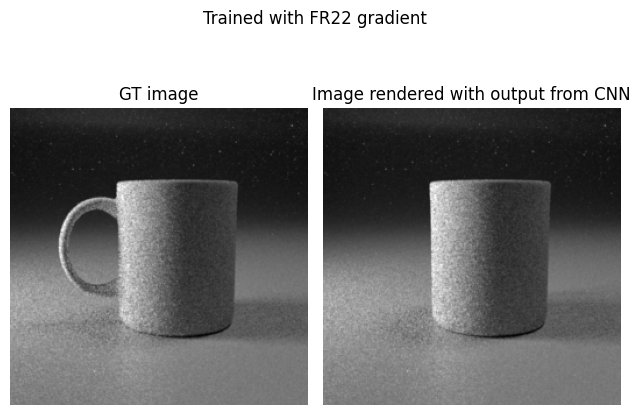

In [165]:
print("Final loss:", loss.item())

# for i in range(72):
#     test_param, test_image = gen_data(gt_param=torch.tensor([(i+1)/4]).to(device))
#     output_param = model(test_image)
#     gt_image = image_for_plotting(test_image)
#     print(f'GT param: {test_param.item()}')
#     print(f'Output param: {output_param.item()}')
test_param, test_image = gen_data()
output_param = model(test_image)
gt_image = image_for_plotting(test_image)
output_param = output_param.item() if isinstance(test_param, (int, float)) else output_param.reshape(test_param.shape)
output_image = image_for_plotting(get_mts_rendering(output_param, update_fn, ctx_args))
print(f'GT param: {test_param}')
print(f'Output param: {output_param}')
    
plt.subplot(1, 2, 1)
plt.imshow(gt_image)
plt.title('GT image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(output_image)
plt.title('Image rendered with output from CNN')
plt.axis('off')
plt.suptitle('Trained with FR22 gradient')
plt.tight_layout()
plt.show()

# Add Our G as decoder

## Setup

In [96]:
update_fn = apply_rotation
hparams['sigma'] = 2
ctx_args = {'scene': scene, 'params': params, 'spp': hparams['render_spp'],                     # rendering
            'init_vpos': initial_vertex_positions, 'mat_id': mat_id, 'update_fn': update_fn,    # rendering
            'sampler': 'importance', 'antithetic': True, 'nsamples': hparams['nsamples'],       # ours
            'sigma': hparams['sigma'], 'device': device}  

f_args = {'update_fn': update_fn, 'ctx_args': ctx_args}
kernel_args = {'sigma': hparams['sigma']}
sampler_args = {'sigma': hparams['sigma'], 'is_antithetic': ctx_args['antithetic'], 'dir':(0,0)}

## Training

In [119]:
# optimization - with FR22 as decoder
n_params = 1  # Number of output parameters
model = CNN(n_params)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.MSELoss()
model.to(device)

diff_func = smoothFn_gradient(func=render_smooth, sampler='importance_gradgauss', n=ctx_args['nsamples'], f_args=f_args,
                        kernel_args=kernel_args, sampler_args=sampler_args, device=device)
max_step = 10000
for i in range(max_step):
    gt_param, input_image = gen_data()
    output_color = model(input_image)

    # ours
    ctx_args['gt_image'] = input_image.permute(1, 2, 0) 
    grad = diff_func(output_color)
    optimizer.zero_grad()
    output_color.backward(gradient=grad)
    # print(grad)
    gt_param = torch.as_tensor(gt_param, device=device).reshape(output_color.shape)
    loss = criterion(output_color, gt_param)
    # loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print(f'Loss at step {i}: {loss.item()}')
    if loss.item() < 1e-5:
        print(f'Converged at step {i}')
        break
        


Loss at step 0: 54.94268798828125
Loss at step 100: 87.89227294921875
Loss at step 200: 33.44319534301758
Loss at step 300: 19.154008865356445
Loss at step 400: 50.74762725830078
Loss at step 500: 43.125003814697266
Loss at step 600: 33.62919616699219
Loss at step 700: 14.063265800476074
Loss at step 800: 18.715848922729492
Loss at step 900: 54.33587646484375
Loss at step 1000: 8.115781784057617
Loss at step 1100: 68.21444702148438
Loss at step 1200: 29.198415756225586
Loss at step 1300: 36.670143127441406
Loss at step 1400: 27.45022201538086
Loss at step 1500: 45.548377990722656
Loss at step 1600: 27.237600326538086
Loss at step 1700: 59.011932373046875
Loss at step 1800: 18.857158660888672
Loss at step 1900: 51.82233810424805
Loss at step 2000: 51.615623474121094
Loss at step 2100: 46.684444427490234
Loss at step 2200: 32.174407958984375
Loss at step 2300: 19.0020809173584
Loss at step 2400: 35.466705322265625
Loss at step 2500: 36.14247512817383
Loss at step 2600: 62.02017593383789


Final loss: 14.952262878417969
GT color: tensor([9.7920], device='cuda:0')
Output color: tensor([3.2986], device='cuda:0', grad_fn=<ViewBackward0>)


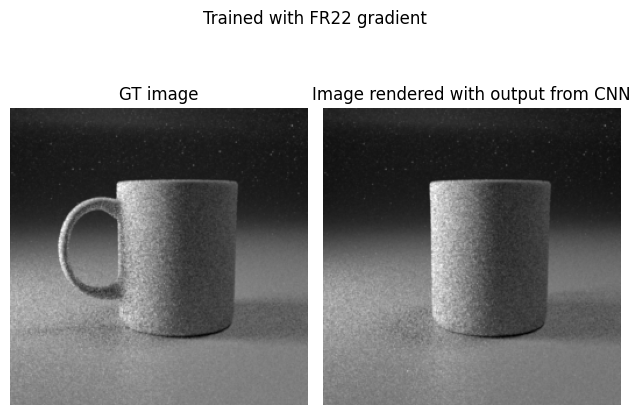

In [123]:
print("Final loss:", loss.item())
test_param, test_image = gen_data()
output_param = model(test_image)
gt_image = image_for_plotting(test_image)

output_param = output_param.item() if isinstance(test_param, (int, float)) else output_param.reshape(test_param.shape)
output_image = image_for_plotting(get_mts_rendering(output_param, update_fn, ctx_args))
print(f'GT color: {test_param}')
print(f'Output color: {output_param}')
plt.subplot(1, 2, 1)
plt.imshow(gt_image)
plt.title('GT image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(output_image)
plt.title('Image rendered with output from CNN')
plt.axis('off')
plt.suptitle('Trained with FR22 gradient')
plt.tight_layout()
plt.show()

# Our HVP

In [ ]:
# setup second order   
n_params = 1  # Number of output parameters
model = CNN(n_params)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()
model.to(device)
func, params = ft.make_functional(model)